# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть EfficientNetB6 и дообучить под нашу задачу. 

В ноутбуке будут использоваться такие приемы, как:
* аугментация при помощи библиотеки albumentations
* политика One Cycle Policy для Learning Rate
* аугментация изображений из тестовой выборки - test time augmentation (TTA)

# Установка и импорт необходимых библиотек

In [1]:
# Обновление tensorflow
!pip install tensorflow --upgrade
# Загрузка модели efficientnet
!pip install -q efficientnet
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

     |████████████████████████████████| 320.4 MB 23 kB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-9ymqaq17
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=28027 sha256=02fa27c73b313db2fb20c2954fa7eb7f243b67ab78f6ab57d04dc93beeb4cceb
  Stored in directory: /tmp/pip-ephem-wheel-cache-s4vp_urp/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [2]:
!nvidia-smi

Tue Oct 13 08:30:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn
import zipfile

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['train.zip', 'train.csv', 'test.zip', 'sample-submission.csv']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


In [4]:
!pip freeze > requirements.txt

# Основные настройки

In [5]:
# Batch size
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
BATCH_SIZE_STEP4     = 4

# Epochs
EPOCHS_STEP1         = 10  # эпох на обучение
EPOCHS_STEP2         = 10  # эпох на обучение  
EPOCHS_STEP3         = 8  # эпох на обучение  
EPOCHS_STEP4         = 8  # эпох на обучение  

# Learning Rates
LR_STEP1             = 1e-3
LR_STEP2             = 1e-4
LR_STEP3             = 1e-5
LR_STEP4             = 1e-5

# Learning Rate One Cycle Policy
MAX_MOMENTUM = 0.98
BASE_MOMENTUM = 0.85
CYCLICAL_MOMENTUM = True
AUGMENT = True
CYCLES = 2.35

# Test-validation split
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 250 # какого размера подаем изображения в сеть
IMG_SIZE_STEP4       = 512

IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

# Создание рабочей директории
os.makedirs(PATH,exist_ok=False)

# Устанавливаем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [6]:
df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [9]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


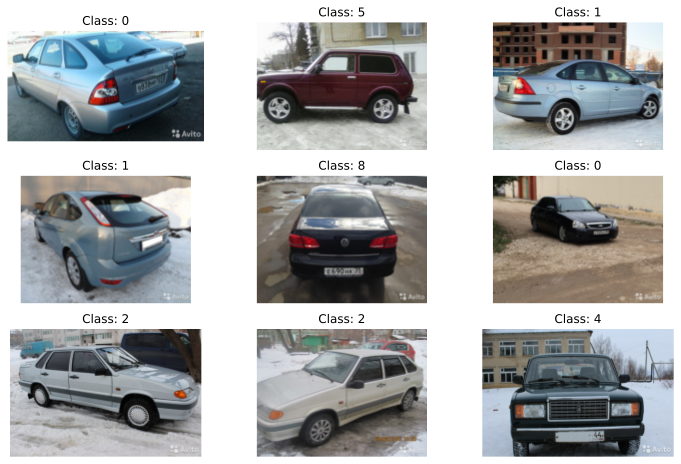

In [10]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

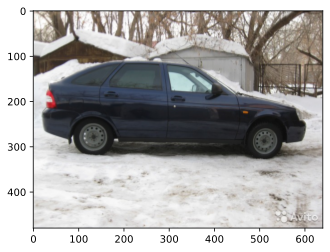

(640, 480)

In [11]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Видим, что классы указывают на модели автомобилей ВАЗ, также присутствуют Ford Focus и Volkswagen Passat

# Подготовка данных

## Аугментация данных

Аугментация с использованием библиотеки Albumentations

In [12]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=250, width=200),
        albumentations.CenterCrop(height=200, width=250),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

## Генерация данных

In [13]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Посмотрим на результат - примеры сгенерированных картинок

Пример картинок из train_generator


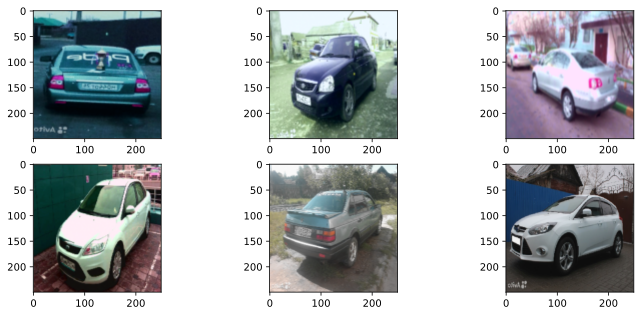

In [14]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


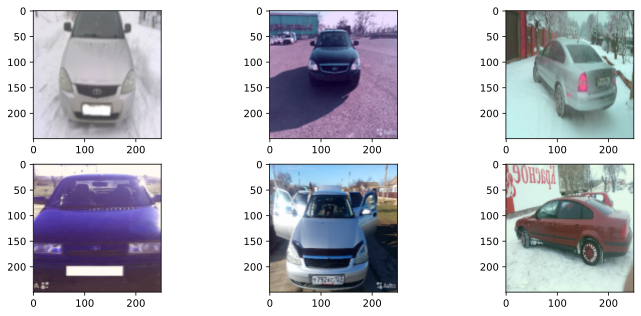

In [15]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

На момент выполнения задания сеть EfficientNetB6 все ещё является оптимальным выбором, если брать во внимание точность предсказаний и время работы.

### Загружаем предобученную сеть EfficientNetB6:

In [16]:
base_model = efn.EfficientNetB6(
    weights='imagenet', # Подгружаем веса imagenet
    include_top=False,  # Выходной слой (голову) будем менять т.к. у нас други классы
    input_shape=input_shape)

165527552/165527152 [==============================] - 2s 0us/step


In [17]:
# Посмотрим на загруженную модель EfficientNetB6
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 125, 125, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 125, 125, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 125, 125, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [18]:
# Для начала заморозим веса EfficientNetB6 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

Устанавливаем "голову"

In [19]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 

# Экспериментируем с архитектурой - добавляем ещё один полносвязный слой, dropout и batch-нормализацию
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))

model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [20]:
# Смотрим на получившуюся модель
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
______________________________________

In [21]:
# Количество слоев
print(len(model.layers))

6


In [22]:
# Количество параметров обучения
len(model.trainable_variables)

6

In [23]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7fed5c4706d0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fed5c39bad0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fede030f110> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe97c9483d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fe97c948d50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fe97c96d8d0> True


# Обучение модели

## Управление Learning Rate - One Cycle Policy

Реализуем one cycle policy. Код взят отсюда: https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras

In [24]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class

from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *

class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

## Step 1 - обучение "головы"

In [25]:
# Настройки
batch_size = BATCH_SIZE
epochs = EPOCHS_STEP1
base_lr = LR_STEP1
max_lr = base_lr*10
max_m = MAX_MOMENTUM
base_m = BASE_MOMENTUM

cyclical_momentum = CYCLICAL_MOMENTUM
augment = AUGMENT
cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]

# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks_list
    )

Epoch 1/10
1556/1556 [==============================] - ETA: 0s - loss: 1.7654 - accuracy: 0.4014
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 220s 142ms/step - loss: 1.7654 - accuracy: 0.4014 - val_loss: 1.1235 - val_accuracy: 0.5905
Epoch 2/10
1556/1556 [==============================] - ETA: 0s - loss: 1.4817 - accuracy: 0.4781
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 208s 134ms/step - loss: 1.4817 - accuracy: 0.4781 - val_loss: 0.9937 - val_accuracy: 0.6598
Epoch 3/10
1556/1556 [==============================] - ETA: 0s - loss: 1.3718 - accuracy: 0.5177
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 212s 136ms/step - loss: 1.3718 - accuracy: 0.5177 - val_loss: 0.9640 - val_accuracy: 0.6637
Epoch 4/10
1556/1556 [==============================] - ETA: 0s - loss: 1.2929 - accuracy: 0.5426
Epoch 00004: saving model to best_model.hdf5
1556/1556 [======

Смотрим, как изменялись learning rate и momentum в процессе обучения

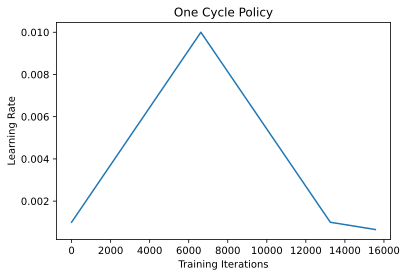

In [26]:
# Plot Learning Rate
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

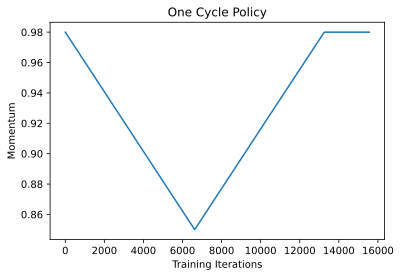

In [27]:
# Plot momentum
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()

In [28]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 43s 111ms/step - loss: 0.7367 - accuracy: 0.7411
Accuracy: 74.11%


In [29]:
# Сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

## Step 2 - FineTuning - обучение половины весов EfficientNetb6

In [30]:
# Посмотрим на количество слоев в базовой модели
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [31]:
# Разморозим базовую модель
base_model.trainable = True

# Установим количество слоев, которые будем переобучать
fine_tune_at = len(base_model.layers)//2

# Заморозим первую половину слоев
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [32]:
# Количество параметров
len(base_model.trainable_variables)

291

In [33]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7fed5c4706d0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fed5c39bad0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fede030f110> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe97c9483d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fe97c948d50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fe97c96d8d0> True


Вновь обучаем модель, используя One Cycle Policy для Learning Rate

In [34]:
# Настройки
#batch_size = BATCH_SIZE
epochs = EPOCHS_STEP2
base_lr = LR_STEP2
max_lr = base_lr*10
#max_m = MAX_MOMENTUM
#base_m = BASE_MOMENTUM

#cyclical_momentum = CYCLICAL_MOMENTUM
#augment = AUGMENT
#cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
#checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
#earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]

# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks_list
)

Epoch 1/10
1556/1556 [==============================] - ETA: 0s - loss: 1.2837 - accuracy: 0.5588
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 299s 192ms/step - loss: 1.2837 - accuracy: 0.5588 - val_loss: 0.5889 - val_accuracy: 0.7787
Epoch 2/10
1556/1556 [==============================] - ETA: 0s - loss: 0.7718 - accuracy: 0.7266
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 294s 189ms/step - loss: 0.7718 - accuracy: 0.7266 - val_loss: 0.4126 - val_accuracy: 0.8560
Epoch 3/10
1556/1556 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.7860
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 291s 187ms/step - loss: 0.6126 - accuracy: 0.7860 - val_loss: 0.3274 - val_accuracy: 0.8821
Epoch 4/10
1556/1556 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8194
Epoch 00004: saving model to best_model.hdf5
1556/1556 [======

In [35]:
# Сохраним модель
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [36]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 40s 103ms/step - loss: 0.1871 - accuracy: 0.9308
Accuracy: 93.08%


## Step 3 - FineTuning - разморозка всей сети EfficientNetB6 и дообучение

Разморозим базовую модель

In [37]:
base_model.trainable = True

Повторно обучим модель, предварительно разморозив все слои

In [38]:
# Настройки
#batch_size = BATCH_SIZE
epochs = EPOCHS_STEP3
base_lr = LR_STEP3
max_lr = base_lr*10
#max_m = MAX_MOMENTUM
#base_m = BASE_MOMENTUM

#cyclical_momentum = CYCLICAL_MOMENTUM
#augment = AUGMENT
#cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
#checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
#earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]

# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks_list
)

Epoch 1/8
1556/1556 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8972
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 573s 368ms/step - loss: 0.2886 - accuracy: 0.8972 - val_loss: 0.1842 - val_accuracy: 0.9336
Epoch 2/8
1556/1556 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.9013
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 571s 367ms/step - loss: 0.2783 - accuracy: 0.9013 - val_loss: 0.1759 - val_accuracy: 0.9394
Epoch 3/8
1556/1556 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8979
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 570s 366ms/step - loss: 0.2954 - accuracy: 0.8979 - val_loss: 0.1668 - val_accuracy: 0.9420
Epoch 4/8
1556/1556 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.9029
Epoch 00004: saving model to best_model.hdf5
1556/1556 [==========

In [39]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [40]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 40s 102ms/step - loss: 0.1656 - accuracy: 0.9415
Accuracy: 94.15%


## Step 4 - увеличение размера изображения

Увеличим размер изображения и уменьшим уровень аугментации

In [41]:
IMG_SIZE             = IMG_SIZE_STEP4
BATCH_SIZE           = BATCH_SIZE_STEP4
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [42]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    # albumentations.OneOf([
    #     albumentations.CenterCrop(height=250, width=200),
    #     albumentations.CenterCrop(height=200, width=250),
    # ],p=0.5),
    # albumentations.OneOf([
    #     albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
    #     albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    # ],p=0.5),
    # albumentations.GaussianBlur(p=0.05),
    # albumentations.HueSaturationValue(p=0.5),
    # albumentations.RGBShift(p=0.5),
    # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    # albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [43]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Заново создаем сеть с новым размером входных данных

In [44]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [45]:
# Настройки
batch_size = BATCH_SIZE_STEP4
epochs = EPOCHS_STEP4
base_lr = LR_STEP4
max_lr = base_lr*10
#max_m = MAX_MOMENTUM
#base_m = BASE_MOMENTUM

#cyclical_momentum = CYCLICAL_MOMENTUM
#augment = AUGMENT
#cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

model.load_weights('best_model.hdf5') # Подгружаем ранее обученные веса

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
#checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
#earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]

# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks_list
)

Epoch 1/8
3113/3113 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.8252
Epoch 00001: saving model to best_model.hdf5
3113/3113 [==============================] - 2109s 677ms/step - loss: 0.5410 - accuracy: 0.8252 - val_loss: 0.1358 - val_accuracy: 0.9604
Epoch 2/8
3113/3113 [==============================] - ETA: 0s - loss: 0.4434 - accuracy: 0.8593
Epoch 00002: saving model to best_model.hdf5
3113/3113 [==============================] - 2103s 676ms/step - loss: 0.4434 - accuracy: 0.8593 - val_loss: 0.1214 - val_accuracy: 0.9598
Epoch 3/8
3113/3113 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.8715
Epoch 00003: saving model to best_model.hdf5
3113/3113 [==============================] - 2105s 676ms/step - loss: 0.3988 - accuracy: 0.8715 - val_loss: 0.1161 - val_accuracy: 0.9656
Epoch 4/8
3113/3113 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8880
Epoch 00004: saving model to best_model.hdf5
3113/3113 [=======

In [46]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [47]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

778/778 [==============================] - 94s 120ms/step - loss: 0.0997 - accuracy: 0.9691
Accuracy: 96.91%


# Предсказание на тестовых данных

In [48]:
from sklearn.metrics import accuracy_score

In [49]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [50]:
test_sub_generator.samples

6675

In [51]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

1669/1669 [==============================] - 192s 115ms/step


In [52]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [53]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


# Test Time Augmentation
https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде.
Взяв среднее значение из нескольких предсказаний получим итоговое предсказание.

In [54]:
model.load_weights('best_model.hdf5')

In [55]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=250, width=200),
        albumentations.CenterCrop(height=200, width=250),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [56]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [57]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

1669/1669 [==============================] - 217s 130ms/step


In [58]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [59]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


In [60]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

# Итоги

К сожалению, использование библиотеки albumentations и применение политики one Cycle для learning rate не дало лучший результат. Ноутбук с лучшим результатом, который мне удалось достичь можно посмотреть здесь: https://colab.research.google.com/drive/1i-L_YSqhuaC2yyI456oEBnQAoYM83bHt?usp=sharing

В ходе выполнения проекта были применены следующие методы:
* transfer learning и fine-tuning
* настройка LR, optimizer, loss
* подобраны переменные (размер картинки, батч и т.д.)
* SOTA архитектура сетей - EfficientNetB6
* добавлена Batch Normalization и изменена архитектура “головы”
* применены дополнительные функции callback Keras https://keras.io/callbacks/ 
* TTA (Test Time Augmentation)
* Дополнительно*: разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: использована более продвинутая библиотеки аугментации изображений (Albumentations )